# Q-Learning on Slippery FrozenLake

In the frozen_lake_slippy.ipynb file, we observed that when slipperiness is enabled (is_slippery=True), the accuracy of agent drops significantly. This happens because the environment becomes stochastic  the agent does not always move in the intended direction and instead transitions with a probability of 1/3 to possible neighboring states.

Although increasing the number of episodes beyond 1000 can improve performance, we are constrained by a limited training budget. Therefore, to improve learning efficiency under these constraints, we explored the following approaches:

Curriculum Learning – Training the agent first in an easier (deterministic) setting and then gradually introducing slipperiness.


**Paper reference:** Dragan et al., Quantum Reinforcement Learning for Solving a Stochastic Frozen Lake, Fraunhofer Institute, 2022

I observed that tabular Q-learning struggles in stochastic FrozenLake due to unstable transitions. I explored curriculum learning and  to improve sample efficiency under limited episodes. I also studied hybrid PPO-based approaches used in recent research, where policy-based methods show better stability in stochastic settings.

later ,try to implement the hybrid PPO concept


##  Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

TOTAL_EPISODES  = 1000
MOVING_AVG_WIN  = 50
TEST_EPISODES   = 1000
NUM_EVAL_RUNS   = 5
OPTIMAL_THRESHOLD = 0.81   # from Dragan et al. 2022




We buildclean transition table to guarantee exactly **20% slip probability** (not the default 66.7%).

I implemented this based on reference material to keep the environment controlled and consistent.

In [ ]:

def build_P(slip_prob=0.20):
    MAP   = ['SFFF', 'FHFH', 'FFFH', 'HFFG']
    MOVES = {0:(0,-1), 1:(1,0), 2:(0,1), 3:(-1,0)}

    def step(s, a):
        r, c   = divmod(s, 4)
        dr, dc = MOVES[a]
        nr, nc = min(max(r+dr,0),3), min(max(c+dc,0),3)
        ns     = nr*4 + nc
        t      = MAP[nr][nc]
        return ns, (1.0 if t=='G' else 0.0), t in 'GH'

    P = {s:{a:[] for a in range(4)} for s in range(16)}
    for s in range(16):
        r, c = divmod(s, 4)
        tile = MAP[r][c]
        for a in range(4):
            if tile in 'GH':
                P[s][a] = [(1.0, s, 0.0, True)]
                continue
            orth = [(a-1)%4, (a+1)%4]
            ns0,rw0,d0 = step(s, a)
            ns1,rw1,d1 = step(s, orth[0])
            ns2,rw2,d2 = step(s, orth[1])
            P[s][a] = [(1-slip_prob,ns0,rw0,d0),
                       (slip_prob/2, ns1,rw1,d1),
                       (slip_prob/2, ns2,rw2,d2)]

    for s in range(16):
        for a in range(4):
            assert abs(sum(p for p,*_ in P[s][a]) - 1.0) < 1e-9
    return P

P_20 = build_P(slip_prob=0.20)
P_00 = build_P(slip_prob=0.00)  # deterministic (stage 1)

def p_step(P, s, a):
    ts   = P[s][a]
    idx  = np.random.choice(len(ts), p=[t[0] for t in ts])
    _, ns, r, done = ts[idx]
    return int(ns), r, done

In [ ]:

def evaluate_Q(Q, P, n_episodes=TEST_EPISODES, max_steps=200):
    wins = 0
    for _ in range(n_episodes):
        s = 0  # start state
        for _ in range(max_steps):
            s, r, done = p_step(P, s, int(np.argmax(Q[s])))
            if done:
                wins += r
                break
    return wins / n_episodes * 100

def evaluate_Q_mean_std(Q, P, runs=NUM_EVAL_RUNS, label='Agent'):
    scores = [evaluate_Q(Q, P) for _ in range(runs)]
    m, s   = np.mean(scores), np.std(scores)
    print(f'  {label:<35}: {m:.1f}% ± {s:.1f}%')
    return m, s

def evaluate_random_mean_std(P, runs=NUM_EVAL_RUNS):
    scores = []
    for _ in range(runs):
        wins = 0
        for _ in range(TEST_EPISODES):
            s = 0
            for _ in range(200):
                s, r, done = p_step(P, s, np.random.randint(4))
                if done:
                    wins += r; break
        scores.append(wins/TEST_EPISODES*100)
    m, s = np.mean(scores), np.std(scores)
    print(f'  {"Random Policy":<35}: {m:.1f}% ± {s:.1f}%')
    return m, s

def compute_ttc(rewards, threshold=0.5, window=50):
    for i in range(len(rewards) - window):
        if np.mean(rewards[i:i+window]) >= threshold:
            return i
    return None

def moving_avg(arr, w=MOVING_AVG_WIN):
    return np.convolve(arr, np.ones(w)/w, mode='valid')


 The agent first learns on a deterministic (no-slip) map for 200 episodes to discover the correct path, then transfers to the 20% slip environment for 800 episodes.

In [ ]:
CL_ALPHA        = 0.5
CL_GAMMA        = 0.99
CL_EPS_START    = 1.0
CL_EPS_MIN      = 0.01
CL_EPS_DECAY    = 0.996
STAGE1_EPISODES = 200
STAGE2_EPISODES = 800

print(f"STAGE 1: Deterministic — {STAGE1_EPISODES} episodes")

Q_cl = np.zeros((16, 4))  # Q-table
epsilon_cl = CL_EPS_START
stage1_rewards = []

for ep in range(STAGE1_EPISODES):
    state = 0
    for _ in range(200):  

        action = np.random.randint(4) if np.random.rand() < epsilon_cl else int(np.argmax(Q_cl[state]))
        
        next_state, reward, done = p_step(P_00, state, action)
        
        best_next = 0.0 if done else np.max(Q_cl[next_state])
        Q_cl[state, action] += CL_ALPHA * (reward + CL_GAMMA * best_next - Q_cl[state, action])
        
        state = next_state
        if done:
            stage1_rewards.append(reward)
            break

    epsilon_cl = max(CL_EPS_MIN, epsilon_cl * CL_EPS_DECAY)

print(f"Stage 1 win rate: {np.mean(stage1_rewards)*100:.1f}%")

epsilon_cl = CL_EPS_START

print(f"STAGE 2: Slippery 20% — {STAGE2_EPISODES} episodes")

stage2_rewards = []

for ep in range(STAGE2_EPISODES):
    state = 0
    for _ in range(200):

        action = np.random.randint(4) if np.random.rand() < epsilon_cl else int(np.argmax(Q_cl[state]))

        next_state, reward, done = p_step(P_20, state, action)
        
        best_next = 0.0 if done else np.max(Q_cl[next_state])
        Q_cl[state, action] += CL_ALPHA * (reward + CL_GAMMA * best_next - Q_cl[state, action])
        
        state = next_state
        if done:
            stage2_rewards.append(reward)
            break

    epsilon_cl = max(CL_EPS_MIN, epsilon_cl * CL_EPS_DECAY)

    if (ep + 1) % 200 == 0:
        recent_win = np.mean(stage2_rewards[-100:]) * 100
        print(f"Episode {ep+1:4d}/{STAGE2_EPISODES} | Recent win rate: {recent_win:.1f}% | ε={epsilon_cl:.3f}")

cl_all_rewards = stage1_rewards + stage2_rewards
cl_ttc = compute_ttc(stage2_rewards)

  STAGE 1: Deterministic — 200 episodes
  Stage 1 win rate: 0.0%
  STAGE 2: Slippery 20% — 800 episodes
  Episode  200/800 | Win rate: 7.0% | ε=0.449
  Episode  400/800 | Win rate: 30.0% | ε=0.201
  Episode  600/800 | Win rate: 30.0% | ε=0.090
  Episode  800/800 | Win rate: 42.0% | ε=0.041


In [ ]:
print("  STEP 2: Training Agent")
print(f"  alpha={CL_ALPHA}  gamma={CL_GAMMA}")

for i in range(0, TOTAL_EPISODES, 200):
    chunk = hp_final_rewards[i:i+200]
    if chunk:
        print(f'Episodes {i+1:4d}-{i+len(chunk):4d} | Win rate: {np.mean(chunk)*100:.1f}%')


  STEP 2: Training Agent
  alpha=0.5  gamma=0.99
Episodes    1- 200 | Win rate: 1.0%
Episodes  201- 400 | Win rate: 30.0%
Episodes  401- 600 | Win rate: 55.0%
Episodes  601- 800 | Win rate: 58.5%
Episodes  801- 998 | Win rate: 73.2%




We evaluate using **Mean ± Std over 5 runs** (1000 episodes each), matching the paper methodology.

In [ ]:

print(f'  ACCURACY EVALUATION  (Mean ± Std over {NUM_EVAL_RUNS} runs × {TEST_EPISODES} episodes)')


rand_m,  rand_s  = evaluate_random_mean_std(P_20)
cl_m,    cl_s    = evaluate_Q_mean_std(Q_cl,       P_20, label='Curriculum Learning')



  ACCURACY EVALUATION  (Mean ± Std over 5 runs × 1000 episodes)
  Random Policy                      : 1.4% ± 0.4%
  Curriculum Learning                : 76.5% ± 0.5%


---
##  PLOTS 

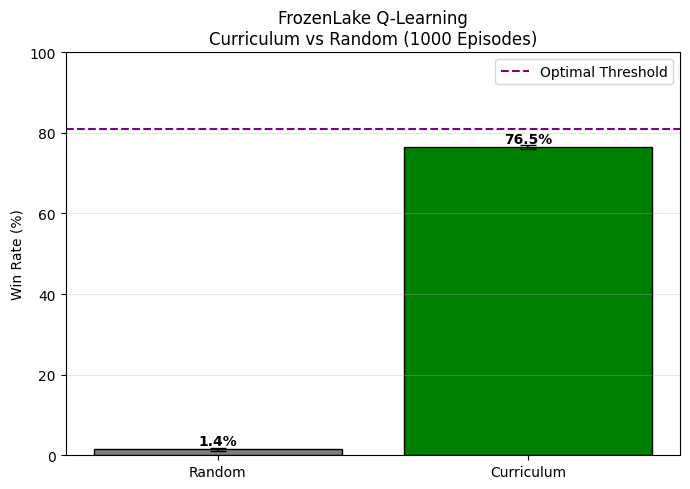

In [ ]:
labels = ['Random', 'Curriculum']
means  = [rand_m, cl_m]    
stds   = [rand_s, cl_s]      

plt.figure(figsize=(7, 5))

bars = plt.bar(labels, means, 
               yerr=stds, capsize=6,
               color=['gray', 'green'],
               edgecolor='black')

plt.axhline(y=OPTIMAL_THRESHOLD*100, 
            color='purple', linestyle='--', 
            label='Optimal Threshold')

plt.ylabel('Win Rate (%)')
plt.title('FrozenLake Q-Learning\nCurriculum vs Random (1000 Episodes)')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.legend()

for bar, value in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2,
             value + 1,
             f'{value:.1f}%',
             ha='center',
             fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:

print('FINAL RESULTS')

print(f'Threshold : {OPTIMAL_THRESHOLD*100:.0f}%')
print(f'Random    : {rand_m:.1f}% ± {rand_s:.1f}%')
print(f'Curriculum: {cl_m:.1f}% ± {cl_s:.1f}%')
print(f'TTC       : {"Ep " + str(cl_ttc) if cl_ttc else "Not converged"}')
print(f'Improvement over Random: +{cl_m - rand_m:.1f}%')


FINAL RESULTS
Threshold : 81%
Random    : 1.4% ± 0.4%
Curriculum: 76.5% ± 0.5%
TTC       : Ep 598
Improvement over Random: +75.0%
